In [ ]:
from Util.prep_data import process_slang, prep
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from wordcloud import WordCloud
from collections import Counter
import re
import numpy as np

In [67]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import split, regexp_replace, col, when, count, abs
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import Row
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

## Preprocessing data mobil bekas dan visualisasi

### Preprocessing dan visualisasi data Mobil Bekas dari platform olx dan mobil123

#### Preprocessing data OLX

In [4]:
# membuat spark session
spark = SparkSession.builder \
	.appName("Rekomendasi Mobil") \
	.config("spark.app.Chatbot", "Chatbot.Rekomendasi Mobil") \
	.getOrCreate()

In [5]:
# spark is an existing SparkSession
df_olx = spark.read.csv("Cache/olx.csv", header=True, inferSchema=True)
# Displays the content of the DataFrame to stdout
df_olx.show()

+--------------------+---------+--------------------+--------------------+----------------+-----------+--------+
|         Link_Produk|    Harga|      tahun_KM_Mobil|         Nama_Produk|   Lokasi_Produk|jenis_mobil|Platform|
+--------------------+---------+--------------------+--------------------+----------------+-----------+--------+
|https://www.olx.c...|102000000|2017 - 40.000-45....|      Daihatsu Sigra|    Medan Satria|     manual|     olx|
|https://www.olx.c...|186000000|   2021 - 0-5.000 km|      Daihatsu Xenia|    Medan Satria|     manual|     olx|
|https://www.olx.c...|178000000|2019 - 45.000-50....|       Wuling Cortez|    Medan Satria|     manual|     olx|
|https://www.olx.c...| 96000000|2015 - 70.000-75....|    Honda Brio Satya|Mampang Prapatan|     manual|     olx|
|https://www.olx.c...|129000000|1992 - 55.000-60....|   Mitsubishi Eterna|    Pesanggrahan|     manual|     olx|
|https://www.olx.c...|227200000|   2024 - 0-5.000 km|          Suzuki XL7|    Pesanggrahan|     

In [6]:
# memisahkan kolom tahun, kilometer min, dan kilometer mobil
df_olx = df_olx.withColumn('temp', split(regexp_replace(col('tahun_KM_Mobil'), ' km', ''), ' - ')) \
    .withColumn('Tahun', col('temp').getItem(0)) \
    .withColumn('temp_km', split(col('temp').getItem(1), '-')) \
    .withColumn('Kilometer_Min', regexp_replace(col('temp_km').getItem(0), '\.', '')) \
    .withColumn('Kilometer_Mobil', regexp_replace(col('temp_km').getItem(1), '\.', '')) \
    .drop('temp', 'temp_km', 'tahun_KM_Mobil')

**Noted:** Membuat 3 kolom baru yaitu tahun, kilometer min, dan kilometer mobil. mengambil data tahun dari baris pertama pada kolom tahun_km_mobil. kemudian membuat kolom baru yang sementara yaitu temp_km dengan memecahkan data berdasarkan simbo '-', lalu membuat kolom baru kilometer min diambil dari baris pertama, dan kilometer mobil diambil dari baris kedua. langkah terkakhir yaitu menghapus kolom yang tidak dibutuhkan lagi seperti temp, temp_km, dan tahun_km_mobil

In [7]:
df_olx.show()

+--------------------+---------+--------------------+----------------+-----------+--------+-----+-------------+---------------+
|         Link_Produk|    Harga|         Nama_Produk|   Lokasi_Produk|jenis_mobil|Platform|Tahun|Kilometer_Min|Kilometer_Mobil|
+--------------------+---------+--------------------+----------------+-----------+--------+-----+-------------+---------------+
|https://www.olx.c...|102000000|      Daihatsu Sigra|    Medan Satria|     manual|     olx| 2017|        40000|          45000|
|https://www.olx.c...|186000000|      Daihatsu Xenia|    Medan Satria|     manual|     olx| 2021|            0|           5000|
|https://www.olx.c...|178000000|       Wuling Cortez|    Medan Satria|     manual|     olx| 2019|        45000|          50000|
|https://www.olx.c...| 96000000|    Honda Brio Satya|Mampang Prapatan|     manual|     olx| 2015|        70000|          75000|
|https://www.olx.c...|129000000|   Mitsubishi Eterna|    Pesanggrahan|     manual|     olx| 1992|       

In [8]:
# mengubah data tahun dan kilometer min yang tidak sesuai
df_olx = df_olx.withColumn('Tahun', 
    when(col('Tahun') == '<1986', '1986')
    .otherwise(col('Tahun')))

df_olx = df_olx.withColumn('Kilometer_Min',
    when(col('Kilometer_Min') == '>300.000', '300000')
    .otherwise(col('Kilometer_Min')))

# mengubah tipe data
df_olx = df_olx.withColumn('Tahun', col('Tahun').cast('integer'))
df_olx = df_olx.withColumn('Kilometer_Mobil', col('Kilometer_Mobil').cast('double'))
df_olx = df_olx.withColumn("Harga", df_olx["Harga"].cast("long"))

In [9]:
# menampilkan nilai pada baris nema produk yang mengandung kata Porsche atau lainnya sesuai dengan kebutuhan
df_olx.filter(split(col('Nama_Produk'), ' ').getItem(0) == 'Porsche').select('Nama_Produk', 'Harga').show()

+--------------+----------+
|   Nama_Produk|     Harga|
+--------------+----------+
|   Porsche 718|2450000000|
|Porsche Cayman|1235000000|
+--------------+----------+



In [10]:
# menghapus kolom yang tidak diperlukan
df_olx = df_olx.drop('Kilometer_Min') 

In [11]:
# menampilkan data olx
df_olx.show()

+--------------------+---------+--------------------+----------------+-----------+--------+-----+---------------+
|         Link_Produk|    Harga|         Nama_Produk|   Lokasi_Produk|jenis_mobil|Platform|Tahun|Kilometer_Mobil|
+--------------------+---------+--------------------+----------------+-----------+--------+-----+---------------+
|https://www.olx.c...|102000000|      Daihatsu Sigra|    Medan Satria|     manual|     olx| 2017|        45000.0|
|https://www.olx.c...|186000000|      Daihatsu Xenia|    Medan Satria|     manual|     olx| 2021|         5000.0|
|https://www.olx.c...|178000000|       Wuling Cortez|    Medan Satria|     manual|     olx| 2019|        50000.0|
|https://www.olx.c...| 96000000|    Honda Brio Satya|Mampang Prapatan|     manual|     olx| 2015|        75000.0|
|https://www.olx.c...|129000000|   Mitsubishi Eterna|    Pesanggrahan|     manual|     olx| 1992|        60000.0|
|https://www.olx.c...|227200000|          Suzuki XL7|    Pesanggrahan|     manual|     o

#### Preprocessing data Mobil123

In [12]:
# import data mobil123
df_mobil123 = spark.read.csv("Cache/mobil123.csv", header=True, inferSchema=True)
# menampilkan data mobil123
df_mobil123.show()

+--------------------+-------------+------------+--------------------+-----------+--------------------+------+-----------+------------+
|         Link_produk|    Kilometer|Lokasi_mobil|   tahun_jenis_mobil|Harga_mobil|         Merek_mobil|Rating|jenis_mobil|    platform|
+--------------------+-------------+------------+--------------------+-----------+--------------------+------+-----------+------------+
|https://www.mobil...|     13000 KM| DKI Jakarta|2004 Suzuki Carib...|     2.25E8|     Suzuki Caribian|   4.8|     manual|mobil123.com|
|https://www.mobil...|     56000 KM|  Jawa Barat|2017 Daihatsu Xen...|      1.4E8|      Daihatsu Xenia|   4.3|     manual|mobil123.com|
|https://www.mobil...|    140000 KM|  Jawa Barat|2013 Toyota Avanz...|      1.3E8|       Toyota Avanza|   4.5|     manual|mobil123.com|
|https://www.mobil...|125 - 130K KM|  Jawa Timur|2013 Nissan Grand...|     1.05E8| Nissan Grand Livina|   4.5|     manual|mobil123.com|
|https://www.mobil...|    110000 KM|      Banten

In [13]:
# mengambil data tahun dari kolom tahun_jenis_mobil
df_mobil123 = df_mobil123.withColumn('Tahun', 
    regexp_replace(split(col('tahun_jenis_mobil'), ' ').getItem(0), '[^0-9]', '')
).withColumn('Tahun', col('Tahun').cast('integer'))

In [14]:
# preprocessing terhdapat data kilometer mobil
# preprocessing terhdapat data kilometer mobil
# split data kilometer yang memiliki tanda '-'
# mengambil nilai pertama dari split data kilometer
#  mengambil nilai kedua dari split data kilometer
df_mobil123 = df_mobil123.withColumn('Kilometer', 
    regexp_replace(regexp_replace(regexp_replace(col('Kilometer'), ' KM', ''), 'K', '000'), ' ', '')) \
    .withColumn('temp', split(col('Kilometer'), '-')) \
    .withColumn('Jarak_Min', col('temp').getItem(0)) \
    .withColumn('Kilometer_Mobil', 
        when(col('temp').getItem(1).isNull(), col('temp').getItem(0))
        .otherwise(col('temp').getItem(1))) \
    .drop('temp', 'Kilometer')

In [15]:
# menghapus kolom yang tidak diperlukan
df_mobil123 = df_mobil123.drop('tahun_jenis_mobil', 'Rating', 'Jarak_Min')

**NOted:** menghapus kolom rating. alasannya yaitu karena pada dataset lainnya (mobil bekas pada platform OLX) tidak terdapat kolom rating, karena nantinya akan dilakukan penggabungan dataframe, antara dataframe df_olx dan df_mobil123

In [16]:
# memfilter data yang memiliki harga mobil null
df_mobil123.filter(col('Harga_mobil').isNull()).show()

# mengambil data yang memiliki harga mobil null
null_count = df_mobil123.filter(col('Harga_mobil').isNull()).count()
print(f"\nTotal number of rows with null Harga_mobil: {null_count}")

+--------------------+------------+-----------+--------------------+-----------+------------+-----+---------------+
|         Link_produk|Lokasi_mobil|Harga_mobil|         Merek_mobil|jenis_mobil|    platform|Tahun|Kilometer_Mobil|
+--------------------+------------+-----------+--------------------+-----------+------------+-----+---------------+
|https://www.mobil...| Jawa Tengah|       NULL|         Toyota Rush|     manual|mobil123.com| 2018|         105000|
|https://www.mobil...| DKI Jakarta|       NULL|       Toyota Avanza|     manual|mobil123.com| 2014|          85000|
|https://www.mobil...|  Jawa Timur|       NULL|       Suzuki Ertiga|     manual|mobil123.com| 2017|          70000|
|https://www.mobil...|  Jawa Barat|       NULL|Nissan Livina X-Gear|     manual|mobil123.com| 2010|         210000|
|https://www.mobil...|  Jawa Barat|       NULL|       Suzuki Escudo|     manual|mobil123.com| 2021|          38000|
|https://www.mobil...|  Jawa Barat|       NULL|            Honda BR|    

In [17]:
# menghapus data null pada kolom Harga_mobil
df_mobil123 = df_mobil123.filter(col('Harga_mobil').isNotNull())

In [18]:
# mengubah tipe data kolom menjadi long dan double
df_mobil123 = df_mobil123.withColumn('Kilometer_Mobil', col('Kilometer_Mobil').cast('double'))
df_mobil123 = df_mobil123.withColumn('Harga_mobil', col('Harga_mobil').cast('long'))


#### Preprocessing dengan menggabungkan 2 dataset

In [19]:
# mengubah nama kolom agar sesuai dngan dataset yang akan di gabungkan
df_mobil123 = df_mobil123.withColumnRenamed("Link_produk", "Link_Produk") \
    .withColumnRenamed("Lokasi_mobil", "Lokasi_Produk") \
    .withColumnRenamed("Harga_mobil", "Harga") \
    .withColumnRenamed("Merek_mobil", "Nama_Produk") \
    .withColumnRenamed("platform", "Platform")

In [20]:
# meggabungkan dua dataset berdasarkan kolom yang sama
df = df_olx.select("Link_Produk", "Harga", "Nama_Produk", "Lokasi_Produk", "jenis_mobil", "Platform", "Tahun", "Kilometer_Mobil") \
    .union(df_mobil123.select("Link_Produk", "Harga", "Nama_Produk", "Lokasi_Produk", "jenis_mobil", "Platform", "Tahun", "Kilometer_Mobil"))

In [21]:
# mengubah nama kolom jenis_mobil menjadi tipe_mobil
df = df.withColumnRenamed("jenis_mobil", "tipe_mobil")

In [22]:
# membuat kolom baru jenis mobil dengan mengambil kata pertama dari kolom nama produk
df = df.withColumn('Jenis_Mobil', split(col('Nama_Produk'), ' ').getItem(0))

In [23]:
# melakukan pengecekan nilai null pada dataset
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+-----------+-----+-----------+-------------+----------+--------+-----+---------------+-----------+
|Link_Produk|Harga|Nama_Produk|Lokasi_Produk|tipe_mobil|Platform|Tahun|Kilometer_Mobil|Jenis_Mobil|
+-----------+-----+-----------+-------------+----------+--------+-----+---------------+-----------+
|          0|    0|          4|            0|         0|       0|    0|              6|          4|
+-----------+-----+-----------+-------------+----------+--------+-----+---------------+-----------+



**Noted**: dari pengecekan missing value. terdapat missing value pada kolom kilometer mobil dan jenis mobil. dikarenakan data missing value tidak banyak maka langkah yang diambil yaitu menghapus baris data yang terdapat missing value

In [24]:
# megnhapus missing values
df = df.na.drop()

In [25]:
# mengubah jenis mobil yang sama tetapi memiliki penulisan yang berbeda
df = df.withColumn('Jenis_Mobil', 
    when(col('Jenis_Mobil') == 'Kia', 'KIA')
    .otherwise(col('Jenis_Mobil'))
)

In [26]:
# melihat tipe data dari dataset
df.printSchema()

root
 |-- Link_Produk: string (nullable = true)
 |-- Harga: long (nullable = true)
 |-- Nama_Produk: string (nullable = true)
 |-- Lokasi_Produk: string (nullable = true)
 |-- tipe_mobil: string (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Tahun: integer (nullable = true)
 |-- Kilometer_Mobil: double (nullable = true)
 |-- Jenis_Mobil: string (nullable = true)



In [27]:
# # Convert Spark DataFrame to Pandas DataFrame and save as CSV
# pandas_df = df.toPandas()
# pandas_df.to_csv("Data/mobil-bekas-spark.csv", index=False)

#### Visualisasi Data

In [ ]:
# mengelompokkan kolom tipe_mobil, Kilometer_Mobil berdasarkan harga
df_vis = df.groupBy(['tipe_mobil','Kilometer_Mobil']).agg({'Harga': 'mean'})\
    .orderBy('avg(Harga)', ascending=False)
print(df_vis.columns)


['tipe_mobil', 'Kilometer_Mobil', 'avg(Harga)']


In [63]:
df_visual = df_vis.toPandas()

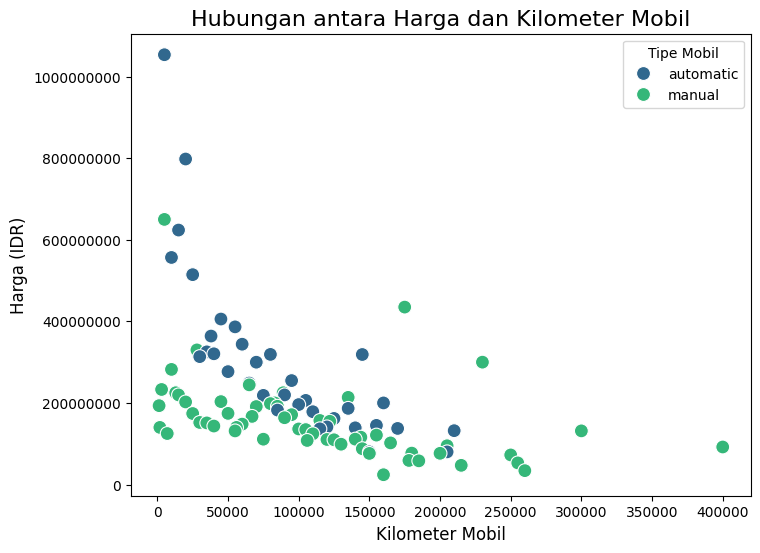

In [65]:

# Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Kilometer_Mobil', y='avg(Harga)', hue='tipe_mobil', data=df_visual, palette='viridis', s=100)
plt.title('Hubungan antara Harga dan Kilometer Mobil', fontsize=16)
plt.xlabel('Kilometer Mobil', fontsize=12)
plt.ylabel('Harga (IDR)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title='Tipe Mobil')
plt.show()

In [70]:
# Buat kolom vektor fitur
feature_cols = ['Harga', 'Kilometer_Mobil', 'Tahun']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vector = assembler.transform(df)

# Hitung matriks korelasi
matrix = Correlation.corr(df_vector, "features").head()[0]

In [71]:
corr_matrix = np.array(matrix.toArray())
corr_df = pd.DataFrame(corr_matrix, index=feature_cols, columns=feature_cols)

# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap Korelasi Fitur Mobil', fontsize=16)
plt.show()

NameError: name 'np' is not defined

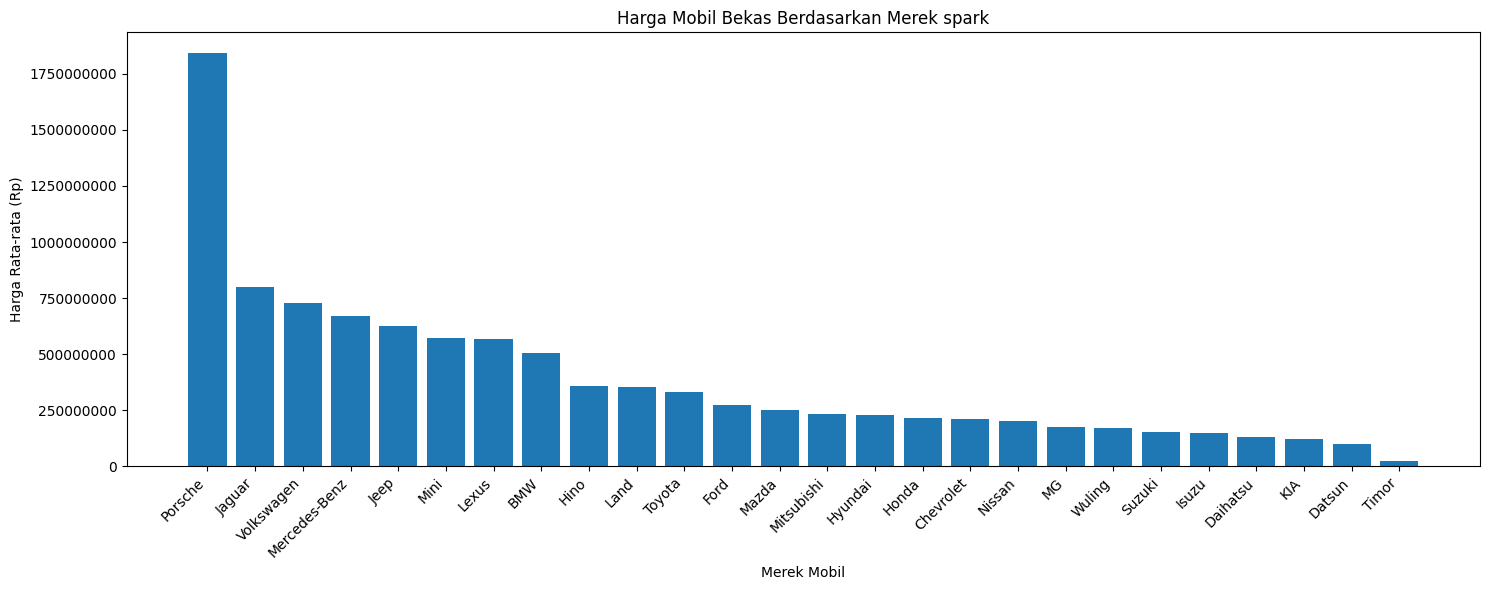

In [28]:
# megnhitung rata-rata harga mobil bekas berdasarkan jenis mobil
avg_price_per_brand = df.groupBy('Jenis_Mobil').agg({'Harga': 'mean'}) \
    .orderBy('avg(Harga)', ascending=False)

# mengubah data frame spark menjadi data frame pandas untuk visualisasi
pdf = avg_price_per_brand.toPandas()

# visualisasi data untuk melihat harga rata-rata mobil bekas berdasarkan jenis mobil
plt.figure(figsize=(15, 6))
plt.bar(pdf['Jenis_Mobil'], pdf['avg(Harga)'])
plt.xticks(rotation=45, ha='right')
plt.title('Harga Mobil Bekas Berdasarkan Merek spark')
plt.xlabel('Merek Mobil')
plt.ylabel('Harga Rata-rata (Rp)')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

**NOted:** 

dari hasil visualisasi yang ada kita dapat mengelompokkan kelas brand mobil yang ada berdasarkan harga. untuk kelas tertinggi adalah brand mobil porsche dengan harga jual lebih dari Rp 1.750 Milliar. terdapat juga kelas premium terdiri dari brand jaguar-BMW  berkisar antara Rp 750 - 500 jt lebih. mobil kelas menengah  terdiri dari brand Hino-nissan dengan harga kurang lebih Rp 250 Juta. sedangkan untuk harga terjangkau teridir dari brand mobil MG-datsun dengan harga kurang dari Rp 250 juta. terdapat juga harga brand mobil timor dengan harga paling terjangkau dibandingkan lainnya.

Harga mobil sendiri dapat dipengaruhi oleh faktor lainnya seperti kondisi mobil, jumlah kilometer, dan juga tipe mobil.

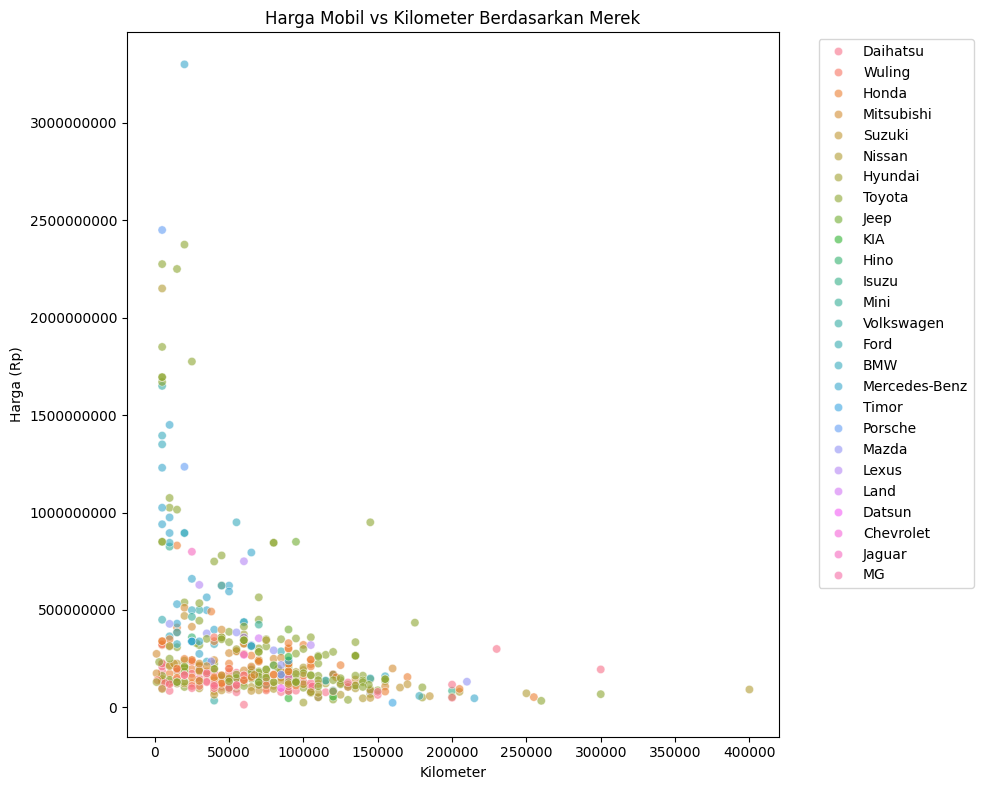

In [29]:
# mengkonversi data frame spark menjadi data frame pandas
plot_df = df.toPandas()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=plot_df, x='Kilometer_Mobil', y='Harga', hue='Jenis_Mobil', alpha=0.6)
plt.title('Harga Mobil vs Kilometer Berdasarkan Merek')
plt.xlabel('Kilometer')
plt.ylabel('Harga (Rp)')
plt.ticklabel_format(style='plain', axis='both')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Noted:** 

dari hasil visualisasi diatas dimana melihat harga brand mobil berdasarkan kilometer mobil. dapat dilihat mobil bekas dibawah 5000 KM memiliki harga jual yang tinggi dibandingkan dengan mobil diatas 5000 KM. sedangkan untuk mobil diatas 5000 - 10.000 KM memliki harga dibawah Rp 1 Milliar. sedangkan untuk mobil diatas 10.000 KM cenderung memiliki harga yang terjangkau dimana kurang dari Rp 500 Juta.

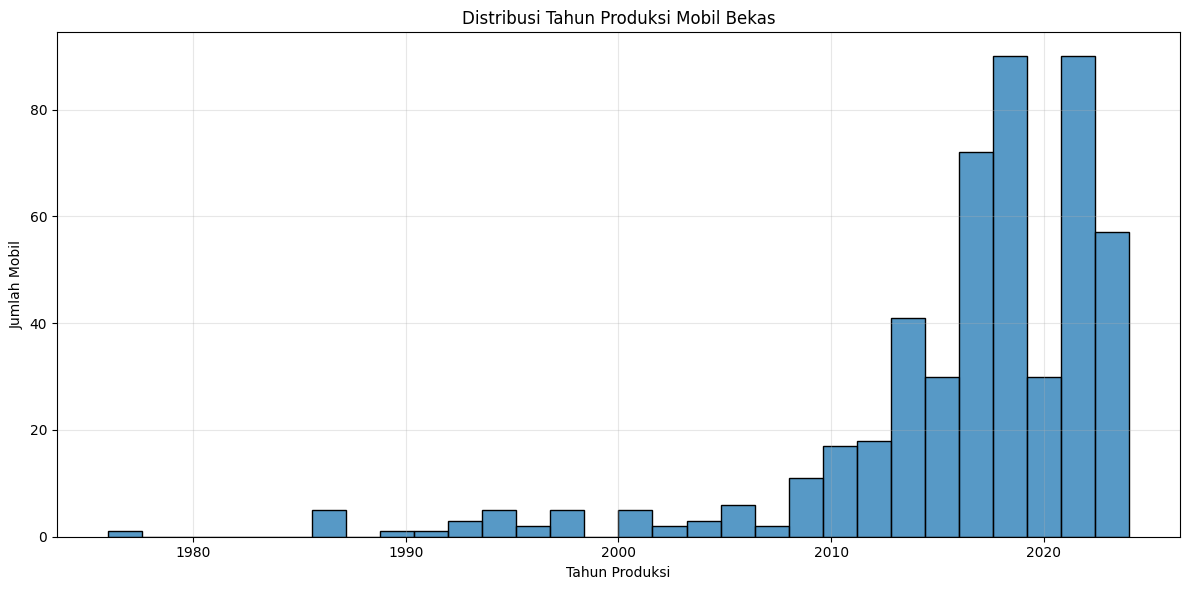

In [30]:
plt.figure(figsize=(12, 6))
sns.histplot(data=plot_df, x='Tahun', bins=30)
plt.title('Distribusi Tahun Produksi Mobil Bekas')
plt.xlabel('Tahun Produksi')
plt.ylabel('Jumlah Mobil')
plt.grid(True, alpha=0.3)
plt.tight_layout()

**Noted**

dari hasil visualisasi  penjualan mobil berdasarkan tahun produksi dapat dilihat bahwa dari mobil produksi tahun 2010 - sebelum tahun 2020 mengalami penignkatan penjualan. sedangkkan untuk mobil pada tahun 2020 mengalami penurunan penjualan, hal ini berkemungkinan karena sempat terjadinya kasus Covid 19 yang bersifat global. dimana covid 19 menganggu perekonomian dan juga aktivitas masyarakat pada saat itu. setelah tahun produksi tahun 2020 penjualan mobil bekas untuk tahun berikut mengalami peningkatan kembali walaupun sempat mengalami penurunan kembali juga, akan tetapi tidak sognifikan dibandingkan dengan mobil produksi tahun 2020.

### Preprocessing Data Chatbot

In [31]:
with open('./Cache/chatbot.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [32]:
# mengubah data json kedalam bentuk dataframe
kategori = []
pertanyaan = []
jawaban = {}
for intent in data['intents']:
    jawaban[intent['tag']] = intent['responses']
    for lines in intent['patterns']:
        pertanyaan.append(lines)
        kategori.append(intent['tag'])
df_chatbot= pd.DataFrame({"tag": kategori, "patterns": pertanyaan})

In [33]:
df_chatbot.head()

,tag,patterns
0,goodbye,terimakasih
1,goodbye,terimakasih atas informasinya
2,goodbye,makasih sangat membantu
3,goodbye,terimakasih atas bantuannya
4,goodbye,selamat tinggal


In [34]:
# Remove punctuation-menghapus tanda baca atau simbol lainnya yang tidak dibutuhkan
df_chatbot['patterns_prep'] = df_chatbot['patterns'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [35]:
# pemrosesan data slang (mengubah kata non-formal menjadi kata formal)
df_chatbot['slang_prep']=df_chatbot['patterns_prep'].apply(process_slang)

In [36]:
df_chatbot['prep'] = df_chatbot['slang_prep'].apply(prep)

In [37]:
df_chatbot['tag'].unique()

array(['goodbye', 'about_car', 'about_chatbot', 'car_recommendation',
       'info_manual_otomatic', 'rekomen_mobil'], dtype=object)

In [38]:
# menyimpan data ke dalam file csv
# df_chatbot.to_csv("Data/prep-data-chatbot.csv", index=False)

In [39]:
# membuat tf-idf vectorizer
vectorizer = TfidfVectorizer()

# fit dan transform data prep dari df_chatbot untuk membuat tf-idf matrix
tfidf_matrix = vectorizer.fit_transform([' '.join(text) for text in df_chatbot['prep']])

# mengambil nama-nama fitur (kata-kata) yang digunakan
feature_names = vectorizer.get_feature_names_out()

# membuat dataframe dari tf-idf matrix untuk visualisasi
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df['tag'] = df_chatbot['tag']

In [40]:
# # menyimpan data ke dalam file csv
# tfidf_df.to_csv("Data/tf-idf-chatbot.csv", index=False)

In [41]:
print("TF-IDF Matrix shape:", tfidf_matrix.shape)

TF-IDF Matrix shape: (837, 502)


In [42]:
tfidf_df.head()

,100,150,200,2020,30,300,50,75,ac,ada,...,utama,velg,vs,wajib,waktu,waspada,wiper,worth,yang,tag
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,goodbye
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,goodbye
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,goodbye
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,goodbye
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,goodbye


#### melakukan visualisasi terhadap data

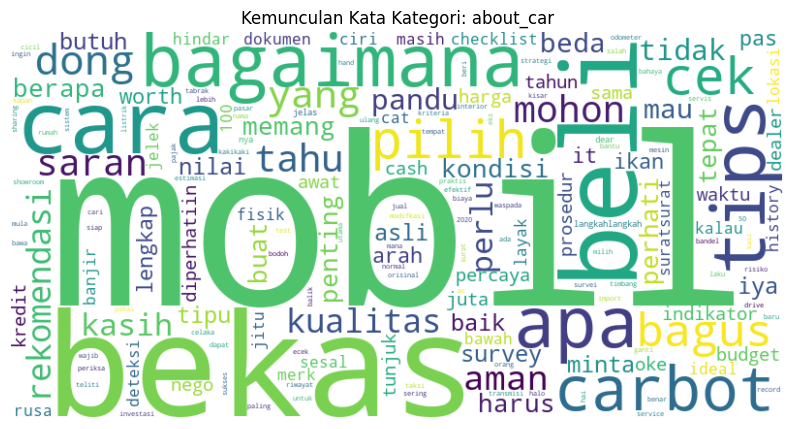

In [43]:
# Filter data untuk kategori tertentu 
kategori = 'about_car'
filtered_data = df_chatbot[df_chatbot['tag'] == kategori]

# Mengumpulkan kata-kata dari teks dalam kategori yang dipilih dan mengubahnya menjadi lowercase
all_text_list = filtered_data['prep'].tolist()
all_words = [word for sublist in all_text_list for word in sublist]  # Menggabungkan list

# Menghitung frekuensi kemunculan kata-kata
word_counts = Counter(all_words)

# Membuat objek WordCloud menggunakan frekuensi kemunculan kata-kata
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Menampilkan word cloud menggunakan matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Kemunculan Kata Kategori: {kategori}")
plt.show()

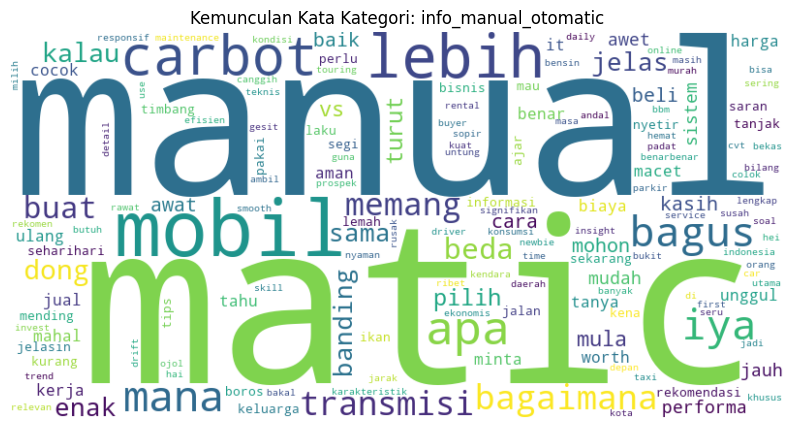

In [44]:
# Filter data untuk kategori tertentu 
kategori = 'info_manual_otomatic'
filtered_data = df_chatbot[df_chatbot['tag'] == kategori]

# Mengumpulkan kata-kata dari teks dalam kategori yang dipilih dan mengubahnya menjadi lowercase
all_text_list = filtered_data['prep'].tolist()
all_words = [word for sublist in all_text_list for word in sublist]  # Menggabungkan list

# Menghitung frekuensi kemunculan kata-kata
word_counts = Counter(all_words)

# Membuat objek WordCloud menggunakan frekuensi kemunculan kata-kata
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Menampilkan word cloud menggunakan matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Kemunculan Kata Kategori: {kategori}")
plt.show()

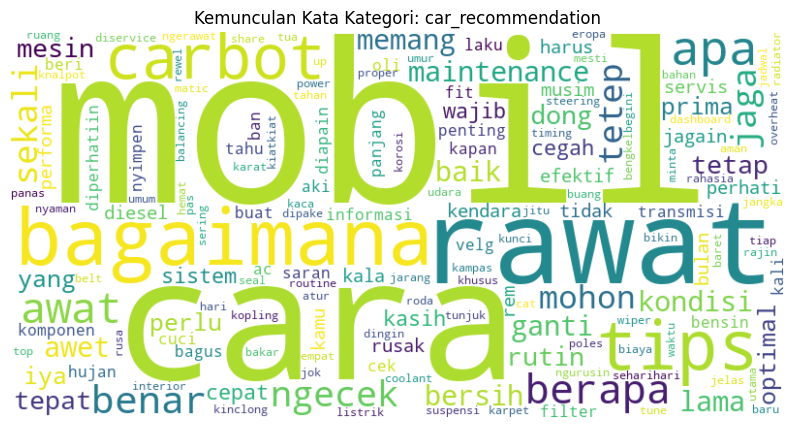

In [45]:
# Filter data untuk kategori tertentu 
kategori = 'car_recommendation'
filtered_data = df_chatbot[df_chatbot['tag'] == kategori]

# Mengumpulkan kata-kata dari teks dalam kategori yang dipilih dan mengubahnya menjadi lowercase
all_text_list = filtered_data['prep'].tolist()
all_words = [word for sublist in all_text_list for word in sublist]  # Menggabungkan list

# Menghitung frekuensi kemunculan kata-kata
word_counts = Counter(all_words)

# Membuat objek WordCloud menggunakan frekuensi kemunculan kata-kata
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Menampilkan word cloud menggunakan matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Kemunculan Kata Kategori: {kategori}")
plt.show()

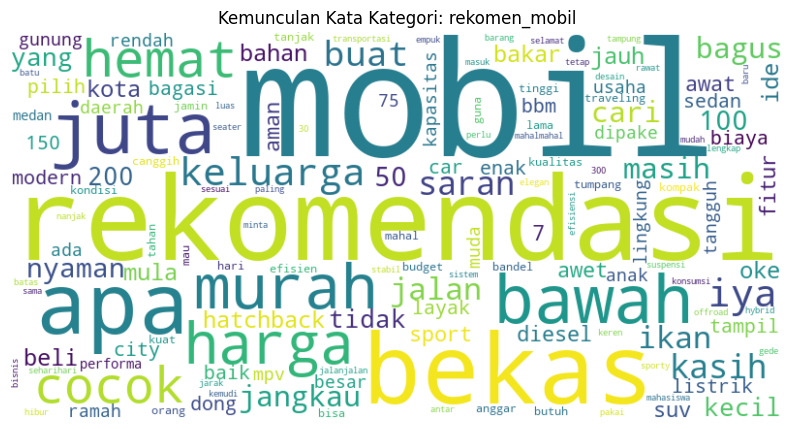

In [46]:
# Filter data untuk kategori tertentu 
kategori = 'rekomen_mobil'
filtered_data = df_chatbot[df_chatbot['tag'] == kategori]

# Mengumpulkan kata-kata dari teks dalam kategori yang dipilih dan mengubahnya menjadi lowercase
all_text_list = filtered_data['prep'].tolist()
all_words = [word for sublist in all_text_list for word in sublist]  # Menggabungkan list

# Menghitung frekuensi kemunculan kata-kata
word_counts = Counter(all_words)

# Membuat objek WordCloud menggunakan frekuensi kemunculan kata-kata
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Menampilkan word cloud menggunakan matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Kemunculan Kata Kategori: {kategori}")
plt.show()

C:\Users\Acer-Nitro\AppData\Local\Temp\ipykernel_18476\3626454099.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


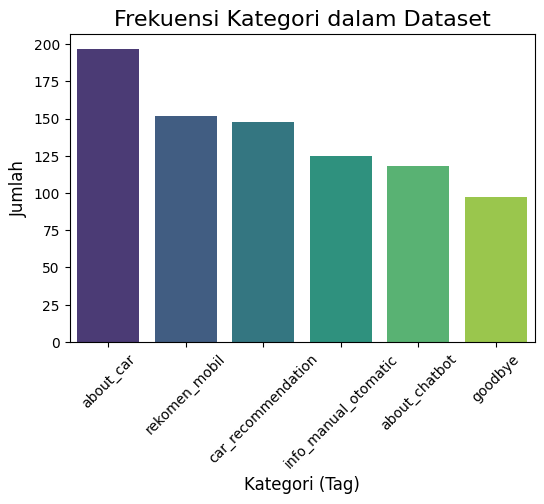

In [49]:
# Hitung frekuensi kategori
category_counts = df_chatbot['tag'].value_counts()

# Visualisasi
plt.figure(figsize=(6, 4))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Frekuensi Kategori dalam Dataset', fontsize=16)
plt.xlabel('Kategori (Tag)', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [48]:
# Hitung rata-rata waktu respons per kategori
response_time_avg = df_chatbot.groupby('tag')['responses'].mean().reset_index()

# Visualisasi
plt.figure(figsize=(8, 6))
sns.lineplot(data=response_time_avg, x='tag', y='responses', marker='o', color='blue')
plt.title('Waktu Respons Chatbot per Kategori', fontsize=16)
plt.xlabel('Kategori', fontsize=12)
plt.ylabel('Waktu Respons (detik)', fontsize=12)
plt.xticks(rotation=45)
plt.show()


KeyError: 'Column not found: responses'